## (i) Importing the necessary packages

In [2]:
%pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 100.8 MB/s eta 0:00:00


In [23]:
#Reference 1: Vaswani, Ashish, et al. “Attention Is All You Need.” ArXiv.org, 6 Dec. 2017, https://arxiv.org/abs/1706.03762. 
#Reference 2: Keras Team. “Keras Documentation: Transformerencoder Layer.” Keras, https://keras.io/api/keras_nlp/layers/transformer_encoder/. 
#Reference 3: Monsoor, Tonmoy, et al. "CNN with data preprocessing.ipynb." BruinLearn, https://bruinlearn.ucla.edu/courses/154235/files/12794459/download?download_frd=1

#The following code is adopted from the "CNN with data preprocessing.ipynb." by Tonmoy Monsoor from ECE C247.

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout,Reshape
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, LeakyReLU
from keras.utils import to_categorical
from keras_nlp.layers import TransformerEncoder
import matplotlib.pyplot as plt
import pickle

np.random.seed(12345)

## (ii)(a) Loading and visualizing the dataset 

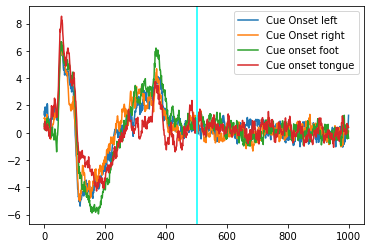

In [24]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("/content/drive/MyDrive/Project Data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Project Data/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/Project Data/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/Project Data/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/Project Data/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/Project Data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





## (ii)(b) Preprocessing the dataset

![EEG_prep.png](attachment:EEG_prep.png)

In [25]:
#Preparing the trimmed dataset based on the specified time bins. 

def data_prep(X,y,sub_sample,average,noise,time):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:time]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


## (iii) Defining the architecture of CNN+Transformer model

In [26]:
def CNN_Transformer(intermediate_dim=6, num_heads=2, add_layer = False,time=250):
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    # Conv. block 1
    basic_cnn_model.add(TransformerEncoder(intermediate_dim=intermediate_dim,num_heads=num_heads,dropout=0.5,activation="elu"))
    basic_cnn_model.add(Reshape((time,1,22)))

    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4

    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))


    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    basic_cnn_model.build((None,time,22))

    # Printing the model summary
    #basic_cnn_model.summary()
    return basic_cnn_model

## (iv) Compiling the CNN+Transformer model and Training the model based on different specified time bins (250, 500, 750, 1000). 

In [32]:
# Compiling the model
from tensorflow import keras

time_results=np.zeros(4)

for i in range(1,5):
    
    time_point=250*i
    X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True,time_point)
    x_train_valid_p = np.swapaxes(X_train_valid_prep, 2,1)
    y_train_valid_p = to_categorical(y_train_valid_prep, 4)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True,time_point)
    y_test_p = to_categorical(y_test_prep, 4)
    x_test_p = np.swapaxes(X_test_prep, 2,1)
    
    print(y_test.shape)

    print(x_train_valid_p.shape)
    learning_rate = 1e-3
    epochs = 100
    decay_steps = 1000
    cnn_optimizer = keras.optimizers.experimental.AdamW(learning_rate=learning_rate)

    
    basic_cnn_model = CNN_Transformer(intermediate_dim=6, num_heads=2, add_layer = True,time=int(time_point/2))
    
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
    basic_cnn_model_results = basic_cnn_model.fit(x_train_valid_p,
                             y_train_valid_p,
                             batch_size=64,
                             epochs=epochs,
                             verbose=True)
    
    cnn_score = basic_cnn_model.evaluate(x_test_p, y_test_p, verbose=0)[1]
    
    #Print the current accuracy with the specified time bins. 

    print(cnn_score)

    time_results[i-1]=cnn_score

np.save("cnn_transformer_timestamp_250_test_result.npy",time_results)

(443,)
(8460, 125, 22)
Epoch 1/100
133/133 [==============================] - 8s 12ms/step - loss: 1.9009 - accuracy: 0.3007
Epoch 2/100
133/133 [==============================] - 2s 11ms/step - loss: 1.5202 - accuracy: 0.3456
Epoch 3/100
133/133 [==============================] - 2s 11ms/step - loss: 1.3483 - accuracy: 0.4021
Epoch 4/100
133/133 [==============================] - 2s 11ms/step - loss: 1.2400 - accuracy: 0.4454
Epoch 5/100
133/133 [==============================] - 2s 15ms/step - loss: 1.1857 - accuracy: 0.4759
Epoch 6/100
133/133 [==============================] - 2s 16ms/step - loss: 1.1476 - accuracy: 0.5041
Epoch 7/100
133/133 [==============================] - 2s 12ms/step - loss: 1.1145 - accuracy: 0.5234
Epoch 8/100
133/133 [==============================] - 1s 11ms/step - loss: 1.0777 - accuracy: 0.5372
Epoch 9/100
133/133 [==============================] - 1s 11ms/step - loss: 1.0460 - accuracy: 0.5543
Epoch 10/100
133/133 [==============================] - 2s 

## (iv) Compiling the CNN+Transformer model and Training the model based on different specified time bins (750, 800, 850, 900, 950, 1000). Time = 750 has the highest accuracy. 

In [34]:
# Compiling the model
from tensorflow import keras

time_results=np.zeros(6)

for i in range(15,21):
    
    time_point=50*i
    X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True,time_point)
    x_train_valid_p = np.swapaxes(X_train_valid_prep, 2,1)
    y_train_valid_p = to_categorical(y_train_valid_prep, 4)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True,time_point)
    y_test_p = to_categorical(y_test_prep, 4)
    x_test_p = np.swapaxes(X_test_prep, 2,1)
    
    print(y_test.shape)

    print(x_train_valid_p.shape)
    learning_rate = 1e-3
    epochs = 100
    decay_steps = 1000
    cnn_optimizer = keras.optimizers.experimental.AdamW(learning_rate=learning_rate)

    
    basic_cnn_model = CNN_Transformer(intermediate_dim=6, num_heads=2, add_layer = True,time=int(time_point/2))
    
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
    basic_cnn_model_results = basic_cnn_model.fit(x_train_valid_p,
                             y_train_valid_p,
                             batch_size=64,
                             epochs=epochs,
                             verbose=True)
    
    cnn_score = basic_cnn_model.evaluate(x_test_p, y_test_p, verbose=0)[1]

    print(cnn_score)

    time_results[i-15]=cnn_score

np.save("cnn_transformer_timestamp_750_1000_by_50_test_result.npy",time_results)

(443,)
(8460, 375, 22)
Epoch 1/100
133/133 [==============================] - 9s 24ms/step - loss: 1.9792 - accuracy: 0.2868
Epoch 2/100
133/133 [==============================] - 4s 28ms/step - loss: 1.5156 - accuracy: 0.3469
Epoch 3/100
133/133 [==============================] - 3s 23ms/step - loss: 1.3224 - accuracy: 0.4175
Epoch 4/100
133/133 [==============================] - 3s 23ms/step - loss: 1.2036 - accuracy: 0.4760
Epoch 5/100
133/133 [==============================] - 3s 23ms/step - loss: 1.1533 - accuracy: 0.4955
Epoch 6/100
133/133 [==============================] - 4s 27ms/step - loss: 1.0873 - accuracy: 0.5346
Epoch 7/100
133/133 [==============================] - 3s 24ms/step - loss: 1.0381 - accuracy: 0.5708
Epoch 8/100
133/133 [==============================] - 3s 24ms/step - loss: 0.9821 - accuracy: 0.5963
Epoch 9/100
133/133 [==============================] - 3s 24ms/step - loss: 0.9265 - accuracy: 0.6275
Epoch 10/100
133/133 [==============================] - 3s 